# Visualizing CNN Decisions

Convolutional Neural Networks have made a lot of progress in Computer Vision. Their accuracy is as good as humans in some tasks. However it remains hard to explain the predictions of convolutional neural networks.

It is often helpful to be able to explain why a model made the prediction it made. For example if a model classifies the following image as a car mirror, it is hard to say why without visualizing the predicted class.

ToDo: Original image | volcano class visualization | car mirror class visualization |

Visualizations also help build confidence about the predictions of a model. For example, even if a model correctly predicts birds as birds, we would want to confirm that the model bases its decision on the features of bird and not on the features of some other object that might occur together with birds in the dataset (like leaves).

In this tutorial, we show how to visualize the predictions made by convolutional neural networks using Gradient-weighted Class Activation Mapping. Unlike many other visualization methods, Grad-CAM can be used on a wide variety of CNN model families - CNNs with fully connected layers, CNNs used for structural outputs (e.g. captioning), CNNs used in tasks with multi-model input (e.g. VQA) or reinforcement learning without architectural changes or re-training.

In the rest of this notebook, we will explain how to visualize predictions made by VGG-16. We begin by importing the required dependencies. `gradcam` (included in this folder) contains the implementation of visualization techniques used in this notebook.

In [1]:
import mxnet as mx
from mxnet import gluon

from matplotlib import pyplot as plt
import numpy as np
import cv2

import gradcam

## Building the network to visualize
Next, we build the network we want to visualize. This code was taken from the Gluon [model zoo](https://github.com/apache/incubator-mxnet/blob/master/python/mxnet/gluon/model_zoo/vision/alexnet.py) and refactored to make it easy to switch between gradcam’s and Gluon’s implementation of ReLU and Conv2D. Same code can be used for both training/inference and visualization with a minor (one line) change.

Notice that we import `ReLU` and `Conv2D` from `gradcam` (included in this folder) instead of `mxnet.gluon.nn`. 
- We use a modified `ReLU` because we use guided backpropagation for visualization and guided backprop requires `ReLU` layer to block the backward flow of negative gradients corresponding to the neurons which decrease the activation of the higher layer unit we aim to visualize. Check [this](https://arxiv.org/abs/1412.6806) paper to learn more about guided backprop.
- We use a modified `Conv2D` (a wrapper on top of Gluon’s `Conv2D`) because we want to capture the output of a given convolutional layer and its gradients. This is needed to implement Grad-CAM. Check [this](https://arxiv.org/abs/1610.02391) paper to learn more about Grad-CAM.

When you are training or running inference, you could just import `Activation` and `Conv2D` from `gluon.nn` instead. No other part of the code needs any change to switch between training/inference and visualization.

In [2]:
import os
from mxnet.gluon.model_zoo import model_store

from mxnet.initializer import Xavier
from mxnet.gluon.nn import MaxPool2D, Flatten, Dense, Dropout, BatchNorm
from gradcam import Activation, Conv2D

class VGG(mx.gluon.HybridBlock):
    def __init__(self, layers, filters, classes=1000, batch_norm=False, **kwargs):
        super(VGG, self).__init__(**kwargs)
        assert len(layers) == len(filters)
        with self.name_scope():
            self.features = self._make_features(layers, filters, batch_norm)
            self.features.add(Dense(4096, activation='relu',
                                       weight_initializer='normal',
                                       bias_initializer='zeros'))
            self.features.add(Dropout(rate=0.5))
            self.features.add(Dense(4096, activation='relu',
                                       weight_initializer='normal',
                                       bias_initializer='zeros'))
            self.features.add(Dropout(rate=0.5))
            self.output = Dense(classes,
                                   weight_initializer='normal',
                                   bias_initializer='zeros')

    def _make_features(self, layers, filters, batch_norm):
        featurizer = mx.gluon.nn.HybridSequential(prefix='')
        for i, num in enumerate(layers):
            for _ in range(num):
                featurizer.add(Conv2D(filters[i], kernel_size=3, padding=1,
                                         weight_initializer=Xavier(rnd_type='gaussian',
                                                                   factor_type='out',
                                                                   magnitude=2),
                                         bias_initializer='zeros'))
                if batch_norm:
                    featurizer.add(BatchNorm())
                featurizer.add(Activation('relu'))
            featurizer.add(MaxPool2D(strides=2))
        return featurizer

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

## Loading pretrained weights
We’ll use pre-trained weights (trained on ImageNet) from model zoo instead of training the model from scratch.

In [3]:
vgg_spec = {11: ([1, 1, 2, 2, 2], [64, 128, 256, 512, 512]),
            13: ([2, 2, 2, 2, 2], [64, 128, 256, 512, 512]),
            16: ([2, 2, 3, 3, 3], [64, 128, 256, 512, 512]),
            19: ([2, 2, 4, 4, 4], [64, 128, 256, 512, 512])}

def get_vgg(num_layers, pretrained=False, ctx=mx.cpu(),
            root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    layers, filters = vgg_spec[num_layers]
    net = VGG(layers, filters, **kwargs)
    if pretrained:
        from mxnet.gluon.model_zoo.model_store import get_model_file
        batch_norm_suffix = '_bn' if kwargs.get('batch_norm') else ''
        net.load_params(get_model_file('vgg%d%s'%(num_layers, batch_norm_suffix),
                                       root=root), ctx=ctx)
    return net

def vgg16(**kwargs):
    return get_vgg(16, **kwargs)

## Preprocessing and other helpers

VGG-16 works on 224x224 images. We’ll resize the input image to 224x224 before feeding it to the network. We normalize the images using the same parameters ImageNet dataset was normalised using to create the pretrained model. These parameters are published [here](https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html). We use `transpose` to convert the image to channel-last format.

Note that we do not hybridize the network. This is because we want `gradcam.Activation` and `gradcam.Conv2D` to behave differently at different times during the execution. For example, `gradcam.Activation` will do the regular backpropagation while computing the gradient of the topmost convolutional layer but will compute guided backprop when computing the gradient of the image.

In [4]:
image_sz = (224, 224)

def preprocess(data):
    data = mx.image.imresize(data, image_sz[0], image_sz[1])
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data

network = vgg16(pretrained=True, ctx=mx.cpu())

We define some helpers to read image files from disk and display multiple images in a row in Jupyter notebook.

In [5]:
def read_image_mxnet(path):
    with open(path, 'rb') as fp:
        img_bytes = fp.read()
    return mx.img.imdecode(img_bytes)

def read_image_cv(path):
    return cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), image_sz)
    #return cv2.resize(cv2.imread(path), image_sz)

def show_images(pred_str, images):
    titles = [pred_str, 'Grad-CAM', 'Guided Grad-CAM', 'Saliency Map']
    num_images = len(images)
    fig=plt.figure(figsize=(15,15))
    rows, cols = 1, num_images
    for i in range(num_images):
        fig.add_subplot(rows, cols, i+1)
        plt.xlabel(titles[i])
        plt.imshow(images[i], cmap='gray' if i==num_images-1 else None)
    plt.show()

synset = []
with open('synset.txt', 'r') as f:
    synset = [l.rstrip().split(' ', 1)[1].split(',')[0] for l in f]
    
def get_class_name(cls_id):
    return "%s (%d)" % (synset[cls_id], cls_id)

def run_inference(net, data):
    out = net(data)
    return out.argmax(axis=1).asnumpy()[0].astype(int)

`visualize` calls `gradcam.visualize()` with the right parameters to create visualizations for the given image. `gradcam.visualize` returns a tuple with the following three visualizations:
1. **Grad-CAM:** This is a heatmap superimposed on the input image showing which part(s) of the image contributed most to the CNN's decision. 
2. **Guided Grad-CAM:** Guided Grad-CAM shows which exact pixels comtributed the most to the CNN's decision.
3. **Saliency map:** Saliency map is a monochrome image showing which pixels contributed the most to the CNN's decision. Sometimes, it is easier to see the areas in the image that most influence the output in a monochrome image than in a color image.

In [6]:
def visualize(net, img_path, conv_layer_name):
    image = read_image_mxnet(img_path)
    image = preprocess(image)
    image = image.expand_dims(axis=0)
    
    pred_str = get_class_name(run_inference(net, image))
    
    orig_img = read_image_cv(img_path)
    vizs = gradcam.visualize(net, image, orig_img, conv_layer_name)
    return (pred_str, (orig_img, *vizs))

Next, we need to get the name of the last convolutional layer that extracts features from the image. We use the gradient information flowing into the last convolutional layer of the CNN to understand the importance of each neuron for a decision of interest. We are interested in the last convolutional layer because convolutional features naturally retain spatial information which is lost in fully connected layers. So, we expect the last convolutional layer to have the best compromise between high level semantics and detailed spacial information. The neurons in this layer look for semantic class specific information in the image (like object parts).

In our network, feature extractors are added to a HybridSequential block named `features`. You can list the layers in that block by just printing `network.features`. You can see that the topmost convolutional layer is at index 28. `alexnet.features[28]._name` will give the name of the layer.

In [7]:
last_conv_layer_name = network.features[28]._name
print(last_conv_layer_name)

vgg0_conv2d12


We now have everything we need to start visualizing. Let’s visualize the CNN decision using few images.

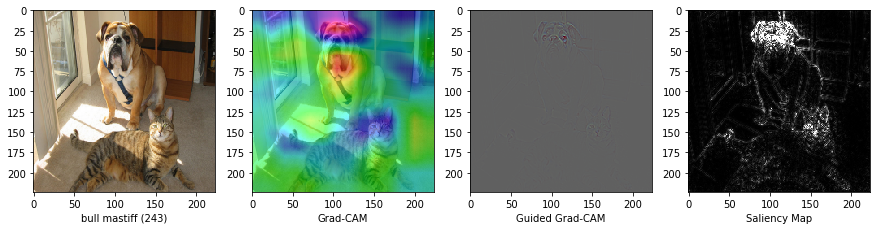

In [8]:
show_images(*visualize(network, "img/cat_dog.png", last_conv_layer_name))

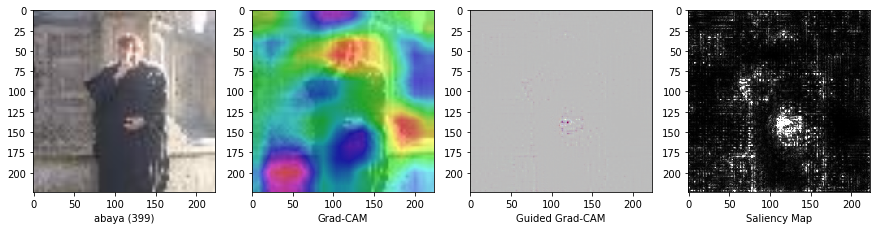

In [9]:
show_images(*visualize(network, "gown.jpg", last_conv_layer_name))

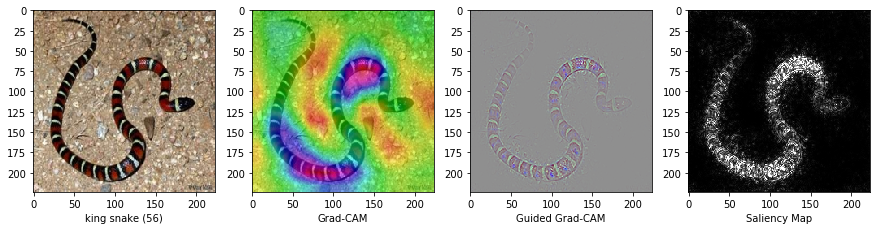

In [10]:
show_images(*visualize(network, "img/snake.jpg", last_conv_layer_name))

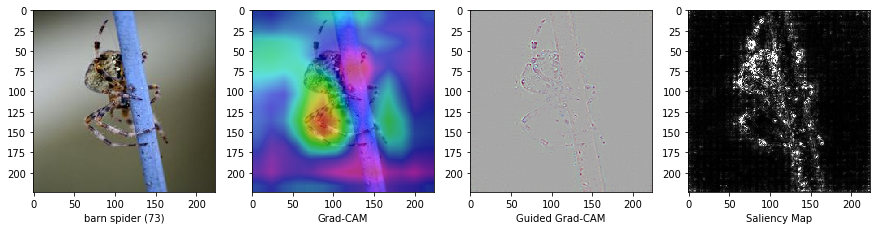

In [11]:
show_images(*visualize(network, "img/spider.png", last_conv_layer_name))

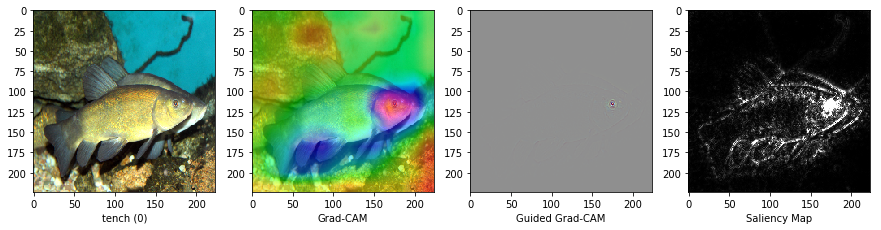

In [12]:
show_images(*visualize(network, "img/fish.jpg", last_conv_layer_name))

Being able to visualize why a CNN makes the decision it makes is a powerful tool to diagnose prediction failures. Even when the network is making correct predictions, visualization is a powerful tool to verify the network is making its decisions based on the right features and not some correlation which happens to exist in the training data. 

Visualization method demonstrated in this tutorial applies to a wide variety of network architectures and a wide variety of tasks beyond classification - like VQA and image captioning. Any type of differentiable output can be used to create the visualizations shown above. Visualization techniques like these solve (atleast partially) the long standing problem of interpretability of neural networks. 